In [1]:
import pandas as pd
import random
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix, accuracy_score, log_loss
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from scipy.spatial.distance import euclidean
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from scipy.stats import chi2_contingency, f_oneway
from sklearn.feature_selection import RFE
from sklearn.model_selection import KFold

# Importing Data

In [2]:
data_train = pd.read_csv('Mushroom_datasets/mushroom_train.csv')
data_test = pd.read_csv('Mushroom_datasets/mushroom_test.csv')
final_accuracy = {}

# Trival System

In [3]:
N = data_train.shape[0]
N1 = data_train[data_train['class']=='p'].shape[0]
N2 = data_train[data_train['class']=='e'].shape[0]
N_test = data_test['class'].shape[0]
y_pred = []

for _ in range(N_test):
    if random.random() < N1/N:
        y_pred.append('p')
    else:
        y_pred.append('e')


accuracy = accuracy_score(data_test['class'], y_pred)
print("Accuracy of test dataset is", accuracy*100, "%")
final_accuracy['Trival System'] = accuracy*100

f_score = f1_score(data_test['class'], y_pred, pos_label='e')
print("F1 score:", f_score)

Accuracy of test dataset is 50.61950766879537 %
F1 score: 0.441232783645235


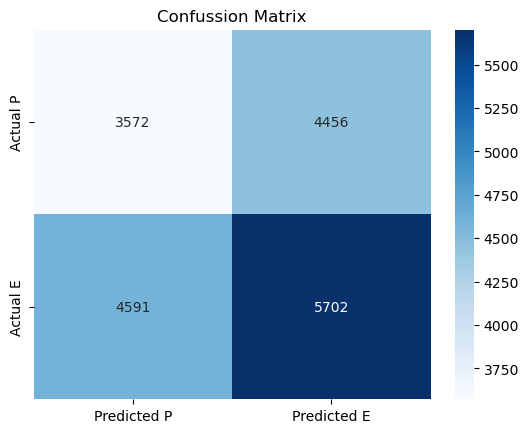

In [4]:
cm = confusion_matrix(data_test['class'], y_pred)
cm_df = pd.DataFrame(cm, index=['Actual P', 'Actual E'], columns=['Predicted P', 'Predicted E'])
sns.heatmap(cm_df, annot=True, cmap='Blues', fmt='g')
plt.title("Confussion Matrix")
plt.show()

# One-Hot Encoding

In [5]:
features = [col for col in data_train.columns if data_train[col].dtype == 'object']
for i in features:
    print("Unique values of", i, ':', data_train[i].unique())

le = LabelEncoder()
features.remove('class')
temp_train = pd.get_dummies(data_train, columns=features)
temp_test = pd.get_dummies(data_test, columns=features)
temp_train['class'] = le.fit_transform(temp_train['class']) 
temp_test['class'] = le.fit_transform(temp_test['class']) 
print()
print("Extra features added =", temp_train.shape[1]-data_train.shape[1])

Unique values of cap-shape : ['c' 'x' 's' 'o' 'f' 'b' 'p']
Unique values of cap-surface : ['i' 'y' 't' 'd' 'g' 'h' 'k' 's' 'e' 'w' 'l']
Unique values of cap-color : ['y' 'r' 'n' 'w' 'g' 'k' 'o' 'l' 'e' 'u' 'b' 'p']
Unique values of does-bruise-or-bleed : ['f' 't']
Unique values of gill-attachment : ['a' 'd' 'p' 'x' 'e' 'f' 's']
Unique values of gill-spacing : ['c' 'd' 'f']
Unique values of gill-color : ['n' 'w' 'g' 'y' 'p' 'k' 'f' 'b' 'e' 'o' 'r' 'u']
Unique values of stem-color : ['w' 'y' 'n' 'r' 'o' 'g' 'l' 'e' 'u' 'f' 'k' 'p' 'b']
Unique values of has-ring : ['f' 't']
Unique values of ring-type : ['f' 'r' 'e' 'z' 'l' 'p' 'g' 'm']
Unique values of habitat : ['d' 'h' 'g' 'l' 'm' 'w' 'p' 'u']
Unique values of season : ['a' 'u' 'w' 's']
Unique values of class : ['p' 'e']

Extra features added = 77


### Spliting dataset into train and test set and perfoming standardization

In [6]:
scaler = StandardScaler()
X_train = temp_train.drop('class', axis=1)
X_train[['cap-diameter', 'stem-height', 'stem-width']] = scaler.fit_transform(X_train[['cap-diameter', 'stem-height', 'stem-width']])
y_train = temp_train['class']
X_test = temp_test.drop('class', axis=1)
X_test[['cap-diameter', 'stem-height', 'stem-width']] = scaler.fit_transform(X_test[['cap-diameter', 'stem-height', 'stem-width']])
y_test = temp_test['class']

# Baseline System

In [7]:
class_means = X_train.groupby(y_train).mean()
y_pred = []
for i in range(len(X_test)):
    distances = []
    for j in range(len(class_means)):
        distances.append(euclidean(X_test.iloc[i], class_means.iloc[j]))
    
    y_pred.append(distances.index(min(distances)))
    
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy of test dataset:", accuracy*100, "%")
final_accuracy['Baseline System'] = accuracy*100

f_score = f1_score(y_test, y_pred)
print("F1 score:", f_score)

Accuracy of test dataset: 62.85683095900879 %
F1 score: 0.6737932026269114


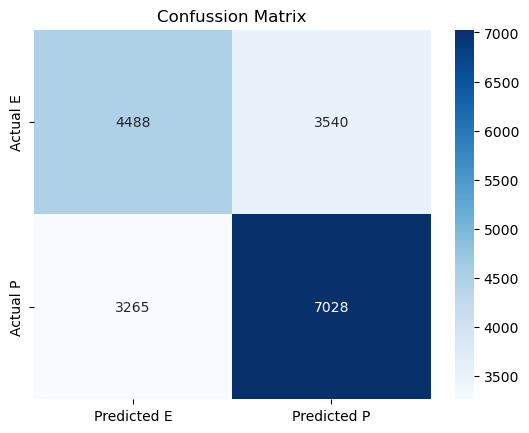

In [8]:
cm = confusion_matrix(y_test, y_pred)
cm_df = pd.DataFrame(cm, index=['Actual E', 'Actual P'], columns=['Predicted E', 'Predicted P'])
sns.heatmap(cm_df, annot=True, cmap='Blues', fmt='g')
plt.title("Confussion Matrix")
plt.show()

# Feature Engineering

## 1) Principal Component Analysis

Best decomposition value: 31
Best accuracy of test dataset: 60.11134763386278 %


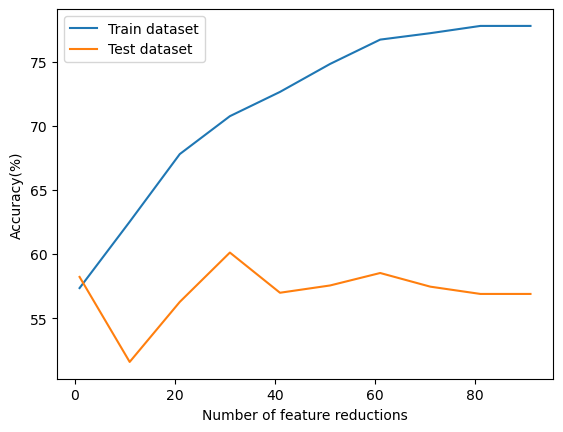

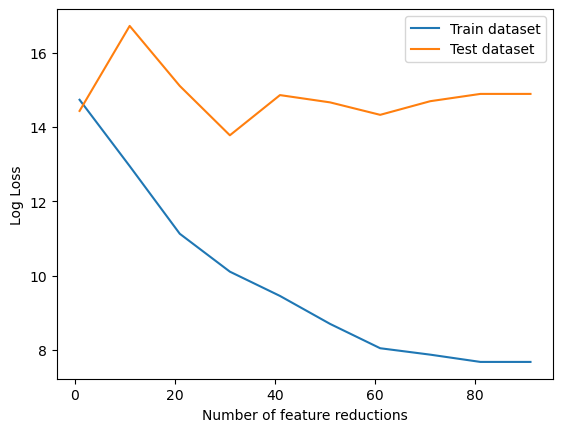

In [9]:
accuracy_train = []
accuracy_test = []
log_loss_train = []
log_loss_test = []
for i in range(1, X_train.shape[1], 10):
    pca = PCA(n_components=i)
    X_pca_train = pca.fit_transform(X_train)
    X_pca_test = pca.fit_transform(X_test)

    lr = LogisticRegression(max_iter=10000)
    lr.fit(X_pca_train, y_train)
    y_pred_train = lr.predict(X_pca_train)
    y_pred = lr.predict(X_pca_test)
    
    log_loss_train.append(log_loss(y_train, y_pred_train))
    log_loss_test.append(log_loss(y_test, y_pred))
    accuracy_train.append(accuracy_score(y_train, y_pred_train))
    accuracy_test.append(accuracy_score(y_test, y_pred))

print("Best decomposition value:", accuracy_test.index(max(accuracy_test))*10+1)
print("Best accuracy of test dataset:", max(accuracy_test)*100, "%")

plt.plot(range(1, X_train.shape[1], 10), np.array(accuracy_train)*100, label='Train dataset')
plt.plot(range(1, X_train.shape[1], 10), np.array(accuracy_test)*100, label='Test dataset')
plt.xlabel("Number of feature reductions")
plt.ylabel("Accuracy(%)")
plt.legend()
plt.show()

plt.plot(range(1, X_train.shape[1], 10), log_loss_train, label='Train dataset')
plt.plot(range(1, X_train.shape[1], 10), log_loss_test, label='Test dataset')
plt.xlabel("Number of feature reductions")
plt.ylabel("Log Loss")
plt.legend()
plt.show()

## 2) Univariate Feature Selection (ANOVA F-test)

/Users/venkatgirianantapatnaikuni/opt/anaconda3/envs/ee559_work/lib/python3.8/site-packages/scipy/stats/_stats_py.py:3872: DegenerateDataWarning: at least one input has length 0
  warnings.warn(stats.DegenerateDataWarning('at least one input '


Best number of features to select: 51
--------------------------------------------------
Best feature set: ['cap-diameter', 'stem-height', 'stem-width', 'stem-color_w', 'gill-attachment_p', 'ring-type_z', 'cap-surface_k', 'cap-shape_b', 'gill-color_w', 'gill-attachment_a', 'cap-color_e', 'stem-color_f', 'gill-color_n', 'cap-color_r', 'cap-color_n', 'gill-attachment_e', 'gill-spacing_d', 'cap-surface_i', 'cap-shape_o', 'season_w', 'cap-color_b', 'habitat_g', 'stem-color_y', 'cap-surface_s', 'habitat_w', 'ring-type_m', 'gill-spacing_c', 'stem-color_p', 'gill-color_b', 'habitat_l', 'cap-color_o', 'stem-color_e', 'habitat_p', 'stem-color_g', 'cap-shape_p', 'cap-shape_x', 'cap-color_p', 'stem-color_b', 'cap-surface_y', 'stem-color_k', 'season_s', 'stem-color_n', 'cap-surface_h', 'gill-color_e', 'has-ring_f', 'has-ring_t', 'ring-type_l', 'habitat_u', 'stem-color_r', 'cap-shape_f', 'gill-attachment_d']
--------------------------------------------------
Best accuracy of test dataset: 77.774138

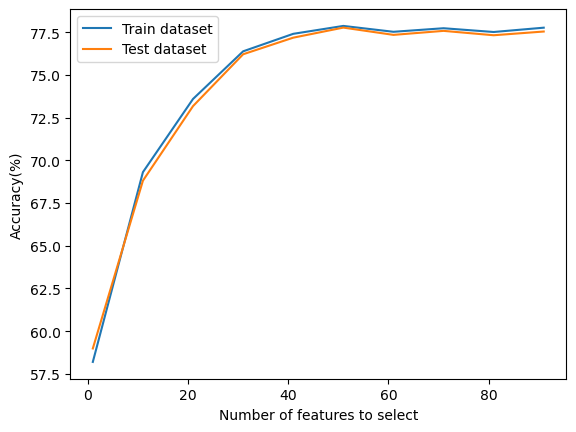

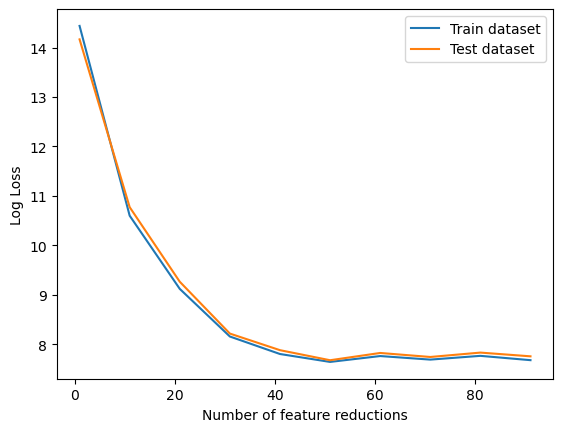

In [10]:
scores = []
for i in range(X_train.shape[1]):
    class_data = []
    
    for j in range(len(np.unique(X_train.iloc[:, i]))):
        class_data.append(y_train[X_train.iloc[:, i]==j])
        
    _, p = f_oneway(*class_data)
    scores.append(p)

feature_scores = sorted(zip(X_train.columns, scores), key=lambda x: x[1])

UFS_accuracy_train = []
UFS_accuracy_test = []
UFS_features_list = []
log_loss_train = []
log_loss_test = []
for i in range(1, len(feature_scores), 10):
    selected_features = [j[0] for j in feature_scores[:i]]
    new_train = X_train[selected_features]
    new_test = X_test[selected_features]
    UFS_features_list.append(selected_features)
    
    lr = LogisticRegression(max_iter=10000)
    lr.fit(new_train, y_train)
    y_pred_train = lr.predict(new_train)
    y_pred = lr.predict(new_test)

    log_loss_train.append(log_loss(y_train, y_pred_train))
    log_loss_test.append(log_loss(y_test, y_pred))
    UFS_accuracy_train.append(accuracy_score(y_train, y_pred_train))
    UFS_accuracy_test.append(accuracy_score(y_test, y_pred))
    
print("Best number of features to select:", len(UFS_features_list[UFS_accuracy_test.index(max(UFS_accuracy_test))]))
print("-"*50)
print("Best feature set:", UFS_features_list[UFS_accuracy_test.index(max(UFS_accuracy_test))])
print("-"*50)
print("Best accuracy of test dataset:", max(UFS_accuracy_test)*100, "%")

plt.plot(range(1, X_train.shape[1], 10), np.array(UFS_accuracy_train)*100, label='Train dataset')
plt.plot(range(1, X_train.shape[1], 10), np.array(UFS_accuracy_test)*100, label='Test dataset')
plt.xlabel("Number of features to select")
plt.ylabel("Accuracy(%)")
plt.legend()
plt.show()

plt.plot(range(1, X_train.shape[1], 10), log_loss_train, label='Train dataset')
plt.plot(range(1, X_train.shape[1], 10), log_loss_test, label='Test dataset')
plt.xlabel("Number of feature reductions")
plt.ylabel("Log Loss")
plt.legend()
plt.show()

## 3) Recursive Feature Elimination

In [ ]:
accuracy_train = []
accuracy_test = []
features_list = []
log_loss_train = []
log_loss_test = []
for i in range(1, X_train.shape[1], 10):
    num_features = i
    selected_features = []
    lr = LogisticRegression(max_iter=10000)

    for i in range(num_features):
        score = []
        for col in X_train.columns:
            if col not in selected_features:
                features = selected_features + [col]
                lr.fit(X_train[features], y_train)
                score.append(lr.score(X_train[features], y_train))
        
        selected_feature = X_train.columns[np.argmin(score)]
        selected_features.append(selected_feature)
    
    new_train = X_train[selected_features]
    features_list.append(selected_features)
    new_train = X_train[selected_features]
    new_test = X_test[selected_features]
    lr.fit(new_train, y_train)
    y_pred_train = lr.predict(new_train)
    y_pred = lr.predict(new_test)

    log_loss_train.append(log_loss(y_train, y_pred_train))
    log_loss_test.append(log_loss(y_test, y_pred))
    accuracy_train.append(accuracy_score(y_train, y_pred_train))
    accuracy_test.append(accuracy_score(y_test, y_pred))
    
print("Best number of features to select:", len(features_list[accuracy_test.index(max(accuracy_test))]))
print("-"*50)
print("Best feature set:", features_list[accuracy_test.index(max(accuracy_test))])
print("-"*50)
print("Best accuracy of test dataset:", max(accuracy_test)*100, "%")

plt.plot(range(1, X_train.shape[1], 10), np.array(accuracy_train)*100, label='Train dataset')
plt.plot(range(1, X_train.shape[1], 10), np.array(accuracy_test)*100, label='Test dataset')
plt.xlabel("Number of features to select")
plt.ylabel("Accuracy(%)")
plt.legend()
plt.show()

plt.plot(range(1, X_train.shape[1], 10), log_loss_train, label='Train dataset')
plt.plot(range(1, X_train.shape[1], 10), log_loss_test, label='Test dataset')
plt.xlabel("Number of feature reductions")
plt.ylabel("Log Loss")
plt.legend()
plt.show()

# Models with cross validation (k=10)

In [25]:
features = UFS_features_list[UFS_accuracy_test.index(max(UFS_accuracy_test))]
splits = 10
X_train = X_train[features]
X_test = X_test[features]

## 1) Logistic Regression

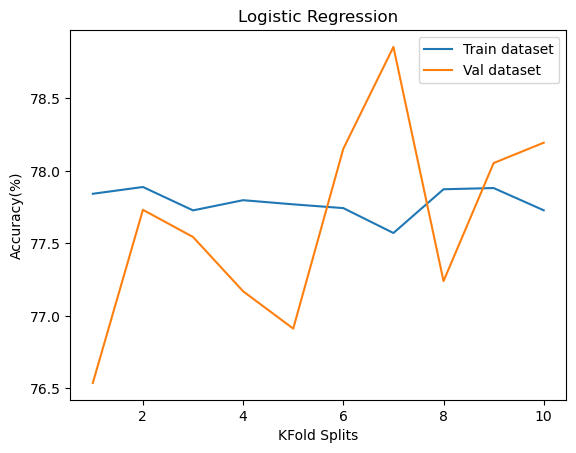

In [12]:
kfold = KFold(n_splits=splits, shuffle=True)
train_accuracy = []
val_accuracy = []
acc = 0

for i,j in kfold.split(X_train):
    train_x, val_x = X_train.iloc[i], X_train.iloc[j]
    train_y, val_y = y_train.iloc[i], y_train.iloc[j]
    
    lr = LogisticRegression(max_iter = 10000).fit(train_x, train_y)
    predict_train = lr.predict(train_x)
    train_accuracy.append(accuracy_score(predict_train, train_y))
    
    predict_val = lr.predict(val_x)
    val_accuracy.append(accuracy_score(predict_val, val_y))
    
    if val_accuracy[-1] > acc:
        acc = val_accuracy[-1]
        update = lr
        
plt.plot(range(1, splits+1), np.array(train_accuracy)*100, label="Train dataset")
plt.plot(range(1, splits+1), np.array(val_accuracy)*100, label="Val dataset")
plt.title("Logistic Regression")
plt.xlabel('KFold Splits')
plt.ylabel('Accuracy(%)')
plt.legend()

In [13]:
y_pred = update.predict(X_test)
final_accuracy['LR'] = accuracy_score(y_pred, y_test)*100
print("Accuracy of test dataset:", final_accuracy['LR'], "%")

Accuracy of test dataset: 77.54489383767262 %


## 2) Support Vector Machine

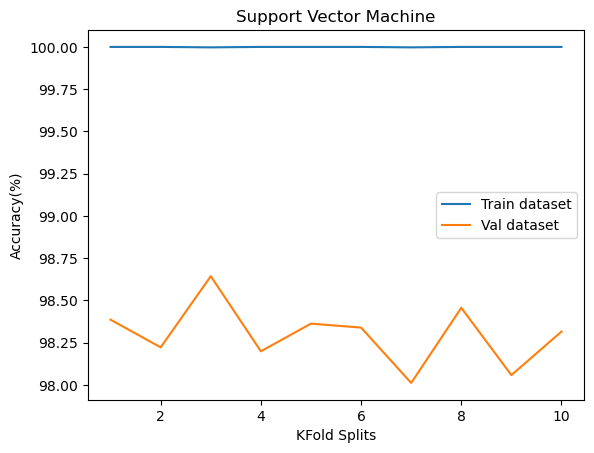

In [14]:
kfold = KFold(n_splits=splits, shuffle=True)
train_accuracy = []
val_accuracy = []
acc = 0

for i,j in kfold.split(X_train):
    train_x, val_x = X_train.iloc[i], X_train.iloc[j]
    train_y, val_y = y_train.iloc[i], y_train.iloc[j]
    
    svm = SVC(kernel='rbf', C=0.5, gamma = 3).fit(train_x, train_y)
    predict_train = svm.predict(train_x)
    train_accuracy.append(accuracy_score(predict_train, train_y))
    
    predict_val = svm.predict(val_x)
    val_accuracy.append(accuracy_score(predict_val, val_y))
    
    if val_accuracy[-1] > acc:
        acc = val_accuracy[-1]
        update = svm
        
plt.plot(range(1, splits+1), np.array(train_accuracy)*100, label="Train dataset")
plt.plot(range(1, splits+1), np.array(val_accuracy)*100, label="Val dataset")
plt.title("Support Vector Machine")
plt.xlabel('KFold Splits')
plt.ylabel('Accuracy(%)')
plt.legend()

In [16]:
y_pred = update.predict(X_test)
final_accuracy['SVM'] = accuracy_score(y_pred, y_test)*100
print("Accuracy of test dataset:", final_accuracy['SVM'], "%")

Accuracy of test dataset: 99.99454178265378 %


## 3) Naive Bayes

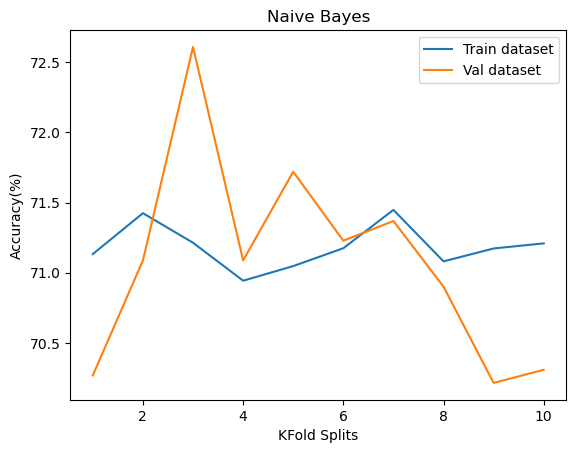

In [17]:
kfold = KFold(n_splits=splits, shuffle=True)
train_accuracy = []
val_accuracy = []
acc = 0

for i,j in kfold.split(X_train):
    train_x, val_x = X_train.iloc[i], X_train.iloc[j]
    train_y, val_y = y_train.iloc[i], y_train.iloc[j]
    
    nb = GaussianNB().fit(train_x, train_y)
    predict_train = nb.predict(train_x)
    train_accuracy.append(accuracy_score(predict_train, train_y))
    
    predict_val = nb.predict(val_x)
    val_accuracy.append(accuracy_score(predict_val, val_y))
    
    if val_accuracy[-1] > acc:
        acc = val_accuracy[-1]
        update = nb

plt.plot(range(1, splits+1), np.array(train_accuracy)*100, label="Train dataset")
plt.plot(range(1, splits+1), np.array(val_accuracy)*100, label="Val dataset")
plt.title("Naive Bayes")
plt.xlabel('KFold Splits')
plt.ylabel('Accuracy(%)')
plt.legend()

In [18]:
y_pred = update.predict(X_test)
final_accuracy['Naive Bayes'] = accuracy_score(y_pred, y_test)*100
print("Accuracy of test dataset:", final_accuracy['Naive Bayes'], "%")

Accuracy of test dataset: 71.18061241198625 %


## 4) Random Forest

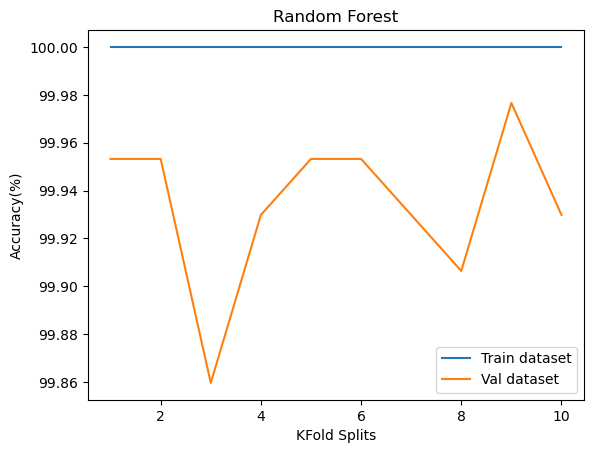

In [26]:
kfold = KFold(n_splits=splits, shuffle=True)
train_accuracy = []
val_accuracy = []
acc = 0

for i,j in kfold.split(X_train):
    train_x, val_x = X_train.iloc[i], X_train.iloc[j]
    train_y, val_y = y_train.iloc[i], y_train.iloc[j]
    
    rfm = RandomForestClassifier(n_estimators=100, random_state=0).fit(train_x, train_y)
    predict_train = rfm.predict(train_x)
    train_accuracy.append(accuracy_score(predict_train, train_y))
    
    predict_val = rfm.predict(val_x)
    val_accuracy.append(accuracy_score(predict_val, val_y))
    
    if val_accuracy[-1] > acc:
        acc = val_accuracy[-1]
        update = rfm
        
plt.plot(range(1, splits+1), np.array(train_accuracy)*100, label="Train dataset")
plt.plot(range(1, splits+1), np.array(val_accuracy)*100, label="Val dataset")
plt.title("Random Forest")
plt.xlabel('KFold Splits')
plt.ylabel('Accuracy(%)')
plt.legend()

In [28]:
y_pred = update.predict(X_test)
final_accuracy['Random Forest'] = accuracy_score(y_pred, y_test)*100
print("Accuracy of test dataset:", final_accuracy['Random Forest'], "%")

Accuracy of test dataset: 99.90175208776813 %


## 5) XgBoost

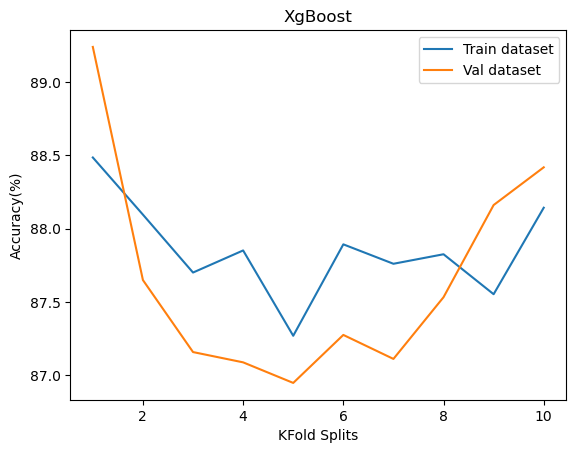

In [29]:
kfold = KFold(n_splits=splits, shuffle=True)
train_accuracy = []
val_accuracy = []
acc = 0

for i,j in kfold.split(X_train):
    train_x, val_x = X_train.iloc[i], X_train.iloc[j]
    train_y, val_y = y_train.iloc[i], y_train.iloc[j]
    
    dtrain = xgb.DMatrix(train_x, label=train_y)
    dval = xgb.DMatrix(val_x, label=val_y)
    params = {'objective': 'binary:logistic', 'eval_metric': 'error', 'max_depth': 3, 'eta': 0.1, 'gamma': 1, 'subsample': 0.8, 'colsample_bytree': 0.8}
    num_rounds = 100
    
    xgb_model = xgb.train(params, dtrain, num_rounds)
    y_pred_train = xgb_model.predict(dtrain)
    y_pred_train_binary = [round(y) for y in y_pred_train]
    train_accuracy.append(accuracy_score(y_pred_train_binary, train_y))
    
    y_pred_test = xgb_model.predict(dval)
    y_pred_test_binary = [round(y) for y in y_pred_test]
    val_accuracy.append(accuracy_score(y_pred_test_binary, val_y))
    
    if val_accuracy[-1] > acc:
        acc = val_accuracy[-1]
        update = xgb_model
        
plt.plot(range(1, splits+1), np.array(train_accuracy)*100, label="Train dataset")
plt.plot(range(1, splits+1), np.array(val_accuracy)*100, label="Val dataset")
plt.title("XgBoost")
plt.xlabel('KFold Splits')
plt.ylabel('Accuracy(%)')
plt.legend()

In [30]:
dtest = xgb.DMatrix(X_test, label=y_test)
predict = update.predict(dtest)
y_pred = [round(y) for y in predict]
final_accuracy['XgBoost'] = accuracy_score(y_pred, y_test)*100
print("Accuracy of test dataset:", final_accuracy['XgBoost'], "%")

Accuracy of test dataset: 88.02467114240488 %


## 6) Multi Layer Perceptron

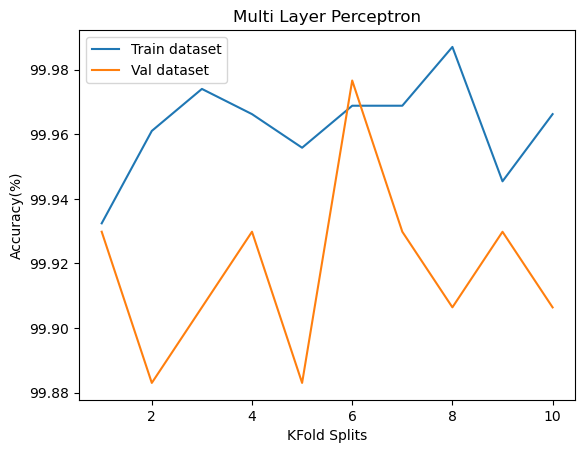

In [31]:
kfold = KFold(n_splits=splits, shuffle=True)
train_accuracy = []
val_accuracy = []
acc = 0

for i,j in kfold.split(X_train):
    train_x, val_x = X_train.iloc[i], X_train.iloc[j]
    train_y, val_y = y_train.iloc[i], y_train.iloc[j]
    
    mlp = MLPClassifier(hidden_layer_sizes=(100,), activation='relu', solver='adam', alpha=0.0001, learning_rate_init=0.001, max_iter=200, early_stopping=False) 
    mlp.fit(train_x, train_y)
    predict_train = mlp.predict(train_x)
    train_accuracy.append(accuracy_score(predict_train, train_y))
    
    predict_val = mlp.predict(val_x)
    val_accuracy.append(accuracy_score(predict_val, val_y))
    
    if val_accuracy[-1] > acc:
        acc = val_accuracy[-1]
        update = mlp
        
plt.plot(range(1, splits+1), np.array(train_accuracy)*100, label="Train dataset")
plt.plot(range(1, splits+1), np.array(val_accuracy)*100, label="Val dataset")
plt.title("Multi Layer Perceptron")
plt.xlabel('KFold Splits')
plt.ylabel('Accuracy(%)')
plt.legend()

In [32]:
y_pred = update.predict(X_test)
final_accuracy['MLP'] = accuracy_score(y_pred, y_test)*100
print("Accuracy of test dataset:", final_accuracy['MLP'], "%")

Accuracy of test dataset: 99.89629387042191 %


## 7) AdaBoost

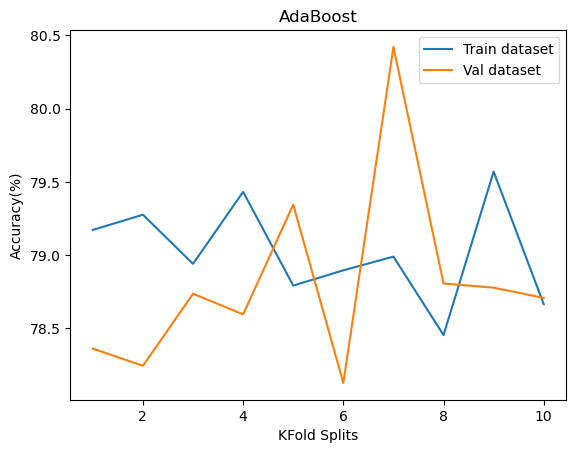

In [33]:
kfold = KFold(n_splits=splits, shuffle=True)
train_accuracy = []
val_accuracy = []
acc = 0

for i,j in kfold.split(X_train):
    train_x, val_x = X_train.iloc[i], X_train.iloc[j]
    train_y, val_y = y_train.iloc[i], y_train.iloc[j]
    
    adaboost_model = AdaBoostClassifier(n_estimators=50, base_estimator=DecisionTreeClassifier(max_depth=1)).fit(train_x, train_y)
    predict_train = adaboost_model.predict(train_x)
    train_accuracy.append(accuracy_score(predict_train,train_y))
    
    predict_val = adaboost_model.predict(val_x)
    val_accuracy.append(accuracy_score(predict_val,val_y))
    
    if val_accuracy[-1] > acc:
        acc = val_accuracy[-1]
        update = adaboost_model
        
plt.plot(range(1, splits+1), np.array(train_accuracy)*100, label="Train dataset")
plt.plot(range(1, splits+1), np.array(val_accuracy)*100, label="Val dataset")
plt.title("AdaBoost")
plt.xlabel('KFold Splits')
plt.ylabel('Accuracy(%)')
plt.legend()

In [34]:
y_pred = update.predict(X_test)
final_accuracy['AdaBoost'] = accuracy_score(y_pred, y_test)*100
print("Accuracy of test dataset:", final_accuracy['AdaBoost'], "%")

Accuracy of test dataset: 78.42912504775941 %


# Final accuracies for all models

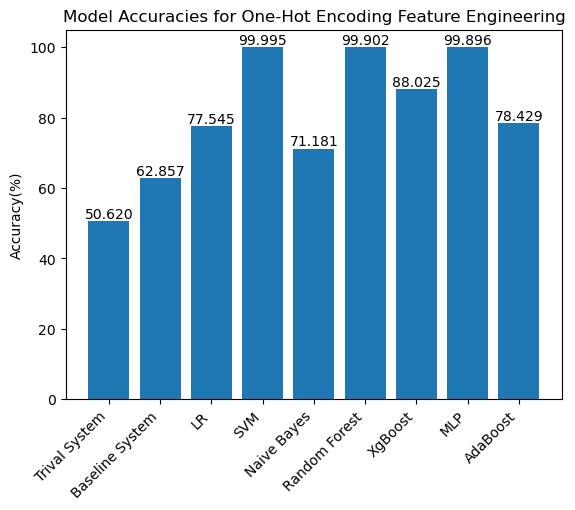

In [44]:
accuracy = list(final_accuracy.keys())
models = list(final_accuracy.values())
plt.xticks(rotation = 45, ha = 'right')
bars = plt.bar(accuracy, models)
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height, '{:.3f}'.format(height), ha = 'center', va = 'bottom')
plt.title("Model Accuracies for One-Hot Encoding Feature Engineering")
plt.ylabel("Accuracy(%)")
plt.show()

In [43]:
best_model = max(final_accuracy, key=final_accuracy.get)
best_accuracy = final_accuracy[best_model]
print(f"Best model is {best_model} with accuracy {best_accuracy} %")

Best model is SVM with accuracy 99.99454178265378 %
